In [ ]:
## The various electrode-by-electrode and trial-by-trial correlation checks I use don't work with Staresina algo for various reasons.
## This version comments out the key lines so the Staresina algo can run
## I'm using the hamming method to select my sub+sess+elec anyway, so don't need to remove bad elecs or sessions here anyway 2021-11-18 JS

# It also loads everything at the bottom and makes the comparison figure I was looking for between Norman and Vaz filters

In [7]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1' 'RepFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [2]:
# sub lists I've been using to explore FR1 

# subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1528E'] #['R1501J'] #['R1587J'] ['R1564J']
# subs = ['R1492J','R1525J']
# subs = ['R1030J','R1035M'] # MFG subs
subs = ['R1108J']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
sub_df = sub_df[2:3]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
599,NaN,protocols/r1/subjects/R1108J/experiments/FR1/s...,protocols/r1/subjects/R1108J/localizations/0/m...,FR1,conversion,0,protocols/r1/subjects/R1108J/experiments/FR1/s...,1,NaN,2,protocols/r1/subjects/R1108J/localizations/0/m...,NaN,2,R1108J,R1108J_1,NaN,protocols/r1/subjects/R1108J/experiments/FR1/s...


In [3]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[4:7]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(565, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2540,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2545,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2549,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


In [8]:
# Want to try and find those files that haven't been made yet (due to memory limits) and re-run only those
# **only an issue with encoding or whole_retrieval due to their large EEG matrices**

### params that clusterRun used
selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 1 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC 
remove_soz_ictal = False
###
# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

rerun_mask = []

for i,row in enumerate(exp_df.itertuples()):
    sub = row.subject; session = row.session; exp = row.experiment

    path_name = '/scratch/john/SWR_scratch/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+'_'+soz_label+'.p') 
    try:
        with open(fn,'rb') as f:
            dat = pickle.load(f)
    except:
        rerun_mask.append(i)
        
# view the rerun_mask
len(rerun_mask)
rerun_df = exp_df.iloc[rerun_mask]
rerun_df

3

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
18,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,1,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
25,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,0,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...


## CLUSTER get SWRs after removing IEDs!

In [10]:
def ClusterRunSWRs(param):

    import pandas as pd
    import numpy as np
    import os
    import sys; sys.path.append('/home1/john/johnModules')
    import dill, pickle
    import mne
    from copy import copy
    from scipy.signal import firwin,filtfilt,kaiserord
    from ptsa.data.filters import ButterworthFilter
    from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                             MFG_labels, IFG_labels, nonHPC_MTL_labels
    %load_ext autoreload
    %autoreload
    from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne
    from general import superVstack,findInd,findAinB
    from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays,getSecondRecalls,\
                        removeRepeatedRecalls,getSWRpathInfo,selectRecallType,correctEEGoffset,\
                        getSerialposOfRecalls,getElectrodeRanges,\
                        detectRipplesHamming,detectRipplesButter,detectRipplesStaresina,getRetrievalStartAlignmentCorrection,\
                        getOutputPositions,getRecallsBeforeIntrusions
        
    import pingouin as pg
    
    ### PARAMS ###

    save_values = 1

    # there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
    selected_period = 'surrounding_recall' 
    # 'surrounding_recall': aligned to time of free recall 
    # 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
    # 'encoding': aligned to word_on 
    # 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
    # 'math': aligned to math problem on
    # 'math_retrieval': aligned to math problem key-in time
    
    recall_type_switch = 0   # switch to determine which recalls to look at! 
    # (as of 2021 always leave this as 0, since I select for 4/6/etc below in the Cluster Load cell)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolated recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
    
    selected_region = HPC_labels   #HPC_labels #HPC_labels # ENT_labels #PHC_labels # temporal_lobe_labels

    remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
    
    # For parametric run across different recall_minimums using recall_type_switch = 3
#     recall_mins = np.arange(3100,5100,100) #[800,900,1100,1200,1300,1400]
# #     recall_mins = [1600,1700,1800,1900,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
#     for recall_minimum in recall_mins:

    # recall params
    recall_minimum = 2000 # time for recall_type_switch = 3 to determine ISOLATED recalls
    IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
    retrieval_whole_time = 30000
    
    # encoding params
    encoding_whole_time = 1000*np.round(12*(1.6)+11*(1.0),1) # this is max time possible for encoding (since ISI is 0.75-1 s) and there is no final ISI
    encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms plus 200 ms buffer
    pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
    # these aren't likely to be changed:
    desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
    
    filter_type = 'butter' # see local version below for details 
    # butter (Vaz algorithm)
    # hamming (Norman algorithm)
    # hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
    # hamming140250 (Same idea, but higher bands)
    # staresina (from Staresina et al 2015 NatNeuro)
    
    eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**
    
    max_ripple_rate = 1.5 # Hz.
    max_trial_by_trial_correlation = 1 #0.05 # if ripples correlated more than this remove them
    max_electrode_by_electrode_correlation = 1 #0.2 #???
    if filter_type == 'hamming':
        min_ripple_rate = 0.1 # Hz.
    else:
        min_ripple_rate = 0 #0.05 # for methods with lower rates decrease the minimum cutoff
        
    soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
    if remove_soz_ictal == 1:
        soz_keep = [0]
    elif remove_soz_ictal == 2:
        soz_keep = [1]
        
    ### END PARAMS ###
    
    # get region label
    if selected_region == HPC_labels:
        region_name = 'HPC'
    elif selected_region == ENT_labels:
        region_name = 'ENT'
    elif selected_region == PHC_labels:
        region_name = 'PHC'
    elif selected_region == temporal_lobe_labels:
        region_name = 'TEMPORALLOBE'
    elif selected_region == MFG_labels:
        region_name = 'MFG'
    elif selected_region == IFG_labels:
        region_name = 'IFG'
    elif selected_region == nonHPC_MTL_labels:
        region_name = 'nonHPC_MTL'    

    # analysis period
    if selected_period == 'surrounding_recall':
        psth_start = -IRI # only makes sense to look at period <= IRI
        psth_end = IRI # how long to grab data after recall
    elif selected_period == 'whole_retrieval':
        psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
        psth_end = IRI+retrieval_whole_time
    elif selected_period == 'whole_encoding':
        psth_start = -2000
        psth_end = encoding_whole_time # +2000    
    elif selected_period == 'encoding':
        psth_start = pre_encoding_time
        psth_end = encoding_time
    elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
        psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
        psth_end = 2000  
   

    ripple_array = []; fr_array = []; 
    trial_nums = []; 
    HPC_names = []; sub_sess_names = []; sub_names = []
    electrodes_per_session = []
    total_lists = 0; total_recalls = 0; kept_recalls = 0
    align_adjust = 0
    ent_elec_ct = []; sd_regions = []; not_sd_regions = []
    ripple_ied_accum_ct = []
    time_add_save = []
    encoded_word_key_array = []; serialpos_array = [] # encoding info 
    list_num_key = []
    
    list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
    serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
    recall_position_array = []; recall_index_array = []
    session_events = pd.DataFrame()
    
    trial_by_trial_correlation = []; elec_by_elec_correlation = []
    session_ripple_rate_by_elec = []; elec_ripple_rate_array = []
    
    channel_coords = []; electrode_labels = []; channel_nums = []

    program_ran = 0
    try:
        with open('temp_dfSWR.p', 'rb') as f: ### change here to avoid overwrite
            temp_df = dill.load(f)   
        row = temp_df[param]
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        # note: if selecting intrusions only, 
        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        if exp == 'RepFR1':
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
        else:
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
        evs_free_recall = evs_free_recall[good_recalls]
        
        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)
        
        if len(evs_free_recall)==0: #...and that any are left!
            sys.exit()
            
        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
        
        # get localizations (region info)
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 
        
        ###  load eeg ###
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list > -1] # remove practice lists **            
            evs_rets = evs_rets[evs_rets.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
        
        elif selected_period == 'whole_encoding':
            # grab whole encoding periods to assess lists with more ripples
            evs_enc = evs[evs.list > -1] # remove practice lists **            
            evs_enc = evs_enc[evs_enc.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 

            # beginning of encoding doesn't have a consistent code, and the last consistent one before it is COUNTDOWN_END, so search for 1st WORD after each
            
            # gotta do this for each individually since it's not a consistent offset across lists (e.g. sometimes COUNTDOWN_END shows up after ORIENT_START)
            countdown_idxs = findInd(evs_enc.type=='COUNTDOWN_END')
            first_word_idxs = []
            for countdown_idx in countdown_idxs:
                got_words = 0
                next_type = 1
                while got_words == 0:
                    if (countdown_idx+next_type)<len(evs_enc):
                        # if you find a WORD, align all the events to this index to get the encoding_starts
                        if evs_enc.iloc[countdown_idx+next_type].type == 'WORD':
                            first_word_idxs.append(countdown_idx+next_type)
                            # reset values
                            got_words = 1
                            next_type = 1                    
                        else:
                            next_type+=1
                    else: # sometimes patients stop working after countdown, so if that happens just get out of while loop and you're done!
                        got_words = 1
                        next_type = 1
            
            eeg_events = evs_enc.iloc[first_word_idxs]            
            
        elif selected_period == 'encoding':
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1] # **
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
            
            evs_math = reader.load('all_events')
            evs_math = evs_math[(evs_math.type=='PROB')]

            # select which recalls??         
            [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_math,IRI,recall_minimum)

            # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
            good_recalls = selected_recalls_idxs & np.array(evs_math.eegoffset>-1) & np.array(evs_math.list > -1) & np.array(evs_math.iscorrect==1)
            evs_math = evs_math[good_recalls]
            eeg_events = copy(evs_math) #$$  
            
            if selected_period == 'math_retrieval': #$$
                temp_eeg = reader.load_eeg(events=eeg_events, rel_start=0, rel_stop=100) # just to get sampling rate
                sr = temp_eeg.samplerate
                sr_factor = 1000/sr
                eeg_events.mstime = eeg_events.mstime+eeg_events.rectime # align to retrieval key-in times...although I don't think this is actually used again?
                eeg_events.eegoffset = eeg_events.eegoffset+[int(v) for v in np.round(eeg_events.rectime/sr_factor).values] # this is only one that matters for aligning to EEG 
                # positive means looking at EEG into the future (when rectime happens)
            
        # fixing bad trials # @@
        if sub == 'R1045E' and exp == 'FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval' | selected_period == 'whole_encoding':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                eeg_events = [] #$$

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #** 
        
        # events X electrodes X time
        sr = eeg.samplerate
        
        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr < 990) and filter_type=='butter': #^^^
            print('Using Vaz algo and sr ≤ 500!')
            sys.exit()

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust,
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #** 
                    sys.exit()
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
        
        # split in half by electrodes so don't run out of memory (reappend in next filtering section)
        half_elec = int(np.shape(eeg_ptsa)[1]/2)
        # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
        eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa[:,:half_elec,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa1, freq_range=[178.,182.], filt_type='stop', order=4).filter()
        eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa[:,half_elec:,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[178.,182.], filt_type='stop', order=4).filter()
#             eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
#             eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
    
        trans_width = 5.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P
            ntaps = np.ceil(ntaps)
        
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')
              

        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # ripple and IED filters
            FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band1 = eeg_ptsa1-filtfilt(FIR_bandstop,1.,eeg_ptsa1)
            eeg_ied_band1 = eeg_ptsa1-filtfilt(bandstop_25_60,1.,eeg_ptsa1)
            eeg_ptsa1 = None
            eeg_rip_band2 = eeg_ptsa2-filtfilt(FIR_bandstop,1.,eeg_ptsa2) 
            eeg_ied_band2 = eeg_ptsa2-filtfilt(bandstop_25_60,1.,eeg_ptsa2)
            eeg_ptsa2 = None
            # re-append here after splitting in half for memory allocation reasons
            eeg_rip_band = eeg_rip_band1.append(eeg_rip_band2,'channel')
            eeg_ied_band = eeg_ied_band1.append(eeg_ied_band2,'channel')
        # let's try a high frequency window that should be more CA1 ripple-only
        elif filter_type == 'hamming125200':
            # ripple and IED filters
            bandstop_125_200 = firwin(int(ntaps+1),[125.,200.],fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            eeg_rip_band = eeg_ptsa-filtfilt(bandstop_125_200,1.,eeg_ptsa) 
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa) 
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #** 
        elif filter_type == 'hamming140250':
            bandstop_140_250 = firwin(int(ntaps+1),[140.,250.],fs=sr, window='hamming',pass_zero='bandstop')
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
            eeg_rip_band = eeg_ptsa-filtfilt(bandstop_140_250,1.,eeg_ptsa) 
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)  
        elif filter_type == 'staresina':
            FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)
            
        eeg_ptsa = None # clear variable for cluster version    
        eeg_rip_band1 = None; eeg_rip_band2 = None 
        eeg_ied_band1 = None; eeg_ied_band2 = None     
        
        
        if filter_type is not 'staresina':
            eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_rip_band.apply_hilbert(envelope=True)
            eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_ied_band.apply_hilbert(envelope=True)          

        
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == True:
                sys.exit() # don't know soz/ictal sites so skip this session
            else:
                elec_cats = [] # not removing these sites anyway so keep on keeping on
#             e = 'No electrode categories for '+sub+', session '+str(session)
#             LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
        if sub == 'R1065J':
            elec_cats = []
        
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        total_electrode_ct = 0
        for channel in electrode_search_range:
            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] in soz_keep): # selecting for SOZ or not ###
                
                total_electrode_ct+=1 # total electrodes before artifact removal 
                
                
                if filter_type is not 'staresina':
                    # get data from MNE container 
                    eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                    eeg_ied = eeg_ied_band.get_data()[:,channel,:]
                else:
                    eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format
                    

                # select detection algorithm (note that iedlogic is same for both so always run that)

                if filter_type.find('hamming') != -1:
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018               
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)             
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)   
                elif filter_type == 'staresina':
                    ripplelogic = detectRipplesStaresina(eeg_rip,sr)                     
                    
                if filter_type == 'butter': # ^^^
                    desired_sample_rate = 1000 # for Vaz algo
                if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)                    
                    
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]               
    
                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = np.sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
#                     print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode

                # check the ripples for this electrode and make sure they're not super correlated across trials

#                 # first, bin the array so can get more realistic correlation not dependent on ms timing
#                 binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
#                 trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
#                 num_cols = len(list(trial_ripple_df))
#                 trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
#                 temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
#                 if temp_tbt_corr > max_trial_by_trial_correlation:
# #                     print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
#                     continue
    
                ## if this electrode passes SAVE data ##
        
#                 trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode 

                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
#                 session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info specific to task periods
                
                if selected_period == 'encoding':
                    encoded_word_key_array.extend(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.extend(eeg_events.serialpos.values)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                    session_events = session_events.append(eeg_events)
                    
                    # for every word place the recall output positions
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]
                    for ln in list_nums:
                        num_words = sum(eeg_events.list==ln)
                        recall_position_array += num_words * [getSerialposOfRecalls(temp_evs_free_recall,eeg_events,ln)] # To add v, n times, to l:
                        
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))

                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls) 
                    
                    # just save the whole dataframe too so I have name and list_num (so I can align to Jim/David's analysis 2021-10-05)
                    session_events = session_events.append(eeg_events)                       
                    
                elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
                    
                    list_nums = eeg_events.list.unique()  
                    for ln in list_nums:
                        num_corr_math = sum(eeg_events.list==ln)
                        list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                        recall_position_array.extend(np.arange(num_corr_math)+1) # correct math position
                    
                    # EEG aligned to rectimes already but this tells you how much earlier problem was shown on screen
                    rectime_array.extend(np.array(eeg_events.rectime)) 
                    encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem

                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = eeg_events.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial 
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there
                        
                    fr_array = superVstack(fr_array,temp_fr_array)
                    # a check to make sure ripplelogic and fr_array have same shape...can probably delete I think I fixed fr_array issues due to encoding list #s above
                    if ripplelogic.shape[0] != temp_fr_array.shape[0]:
                        e = 'Problem is '+sub+str(session)+'_'+str(channel)+'_ripplelogic shape: '+str(ripplelogic.shape[0])+'_fr_array shape: '+str(temp_fr_array.shape[0])
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                        
                elif selected_period == 'whole_encoding':
                    
                    list_nums = eeg_events.list.unique() # only lists with EEG
                    # get recalls again since evs_free_recall is designed for surrounding_recall analysis so some recalls are thrown away
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(temp_evs_free_recall,word_evs,ln)
                        # encoding serialpos
                        serialpos_array.append(temp_sp)
                        # recall position per list
                        recall_position_array.append(np.arange(len(temp_sp))+1) # 1-indexed  
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there    
                        
                        # To analyze the word and ISI periods during encoding, going to record times of each word
                        # this gets each word start time relative to encoding_start (note there is no final ISI it goes straight into distractor)
                        encoded_word_key_array.append(word_evs[word_evs.list==ln].mstime.values-eeg_events[eeg_events.list==ln].mstime.values)                        
                
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_sess_names.append(sub+'-'+str(session))
                sub_names.append(sub)
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(eeg_events.list)
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt')    
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
        
        program_ran = 1          
        # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
#         if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
#             session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
#             num_cols = len(list(session_ripple_df))
#             session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
#             elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs 
#             if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
# #                 e = sub+', '+str(session)+' had correlation over '+str(max_electrode_by_electrode_correlation)+\
# #                     ' b/w electrodes so skipped; corr = '+str(elec_by_elec_correlation)
# #                 LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt')
#                 program_ran = 0

    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterRunSWR_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        #continue

    if save_values == 1 and program_ran == 1:
        
        # get strings for path name for save and loading cluster data
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
        
        path_name = '/scratch/john/SWR_scratch/'+subfolder
        if os.path.isdir(path_name) == False:
            os.mkdir(path_name)
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'-NOCUTOFFS.p')     # +'_no_param_removal.p')   #+'.p')  #+'.intrusions.p') #'.-wrong.p')
        with open(fn,'wb') as f:
            pickle.dump({'region_electrode_ct':region_electrode_ct,'total_electrode_ct':total_electrode_ct, 
                        'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                        'ripple_array':ripple_array, 'time_add_save':time_add_save,
                        'trial_nums':trial_nums,'list_num_key':list_num_key,
                        'encoded_word_key_array':encoded_word_key_array,
                        'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                        'rectime_array':rectime_array,'session_events':session_events,
                        'recall_before_intrusion_array':recall_before_intrusion_array,
                        'recall_position_array':recall_position_array,'recall_index_array':recall_index_array, # ~~
                        'fr_array':fr_array, 'sub_names':sub_names,
                        'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                        'trial_by_trial_correlation':trial_by_trial_correlation, # one value for each electrode for this session
                        'elec_by_elec_correlation':elec_by_elec_correlation,
                        'elec_ripple_rate_array':elec_ripple_rate_array,
                        'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)

os.chdir('/home1/john/SWR/cluster') # where temp files will go

# save as dill so can bypass pickling in ipython for cluster parallelization
import dill
temp_df = list(exp_df.itertuples()) # exp_df is whole enchilada! sub_df to test things. rerun_df if there were memory errors (see above)
with open('temp_dfSWR.p', 'wb') as f: 
    dill.dump(temp_df,f)
params = []
for i in range(len(temp_df)):
    params.append(i)

ClusterRun(ClusterRunSWRs, params)

print('finished ClusterRunSWRs!!')

25 Engines running
Sending a shutdown signal to the controller and engines.


CompositeError: one or more exceptions from call to method: ClusterRunSWRs
[17:apply]: SystemExit: 
[24:apply]: SystemExit: 
[7:apply]: SystemExit: 
[22:apply]: SystemExit: 
.... 67 more exceptions ...

In [11]:
fileDeleter("/home1/john/SWR/cluster/","sge_engine")
fileDeleter("/home1/john/SWR/cluster/","sge_controller")
fileDeleter("/home1/john/SWR/cluster/","bcbio-")

## Load CLUSTER data

## ONLY LOAD SUBJECTS, SESSIONS, AND CHANNELS that were loaded using Norman algo (got via original SWRanalysis)

In [50]:
# load df from hamming run so can take only trials that loaded from it
hamming_df = pd.read_csv('/home1/john/SWR/compiled/hamming_df.csv') 
hamming_df = hamming_df.drop_duplicates()

In [76]:
## Now to load data from cluster, have to go through and append across sessions



selected_period = 'surrounding_recall'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 4
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'staresina' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)


## select only subjects/sessions/channels from hamming_df ##

load_idxs = np.zeros(len(subject_name_array))
for i_trial in range(len(subject_name_array)):
    if ((hamming_df.subject == subject_name_array[i_trial]) & 
         (hamming_df.session == session_name_array[i_trial]) & 
         (hamming_df.channel_num == channel_nums_array[i_trial])).any():
        load_idxs[i_trial] = True



if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
        
    # grab correct recall type *AND* trials that were in hamming_df
    temp_recall_idxs = ((temp_recall_idxs) & (load_idxs==1))
        
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    session_events = session_events[temp_recall_idxs]
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2021-11-19_00-57-14: DF Exception: Sub: R1001P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1001P_0_HPC_surrounding_recall_soz_in_staresina.p', file: <ipython-input-76-b66d985df3b8>, line no: 66
2021-11-19_00-57-14: DF Exception: Sub: R1001P, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1001P_1_HPC_surrounding_recall_soz_in_staresina.p', file: <ipython-input-76-b66d985df3b8>, line no: 66
2021-11-19_00-57-14: DF Exception: Sub: R1034D, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1034D_0_HPC_surrounding_recall_soz_in_staresina.p', file: <ipython-input-76-b66d985df3b8>, line no: 66
2021-11-19_00-57-14: DF Exception: Sub: R1034D, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_FR1_R1034D_1_HPC_surrounding_recall_soz_in_staresina.p', file:

96.40718562874252

% of HPC recalls for FR1


38.94599202211298

(23530, 2000)

From 317/475 sessions with >0 HPC electrodes
Total trials: 71993
Unique sessions: 317
...from 139 patients
Number of electrodes: 603
Electrode regions X sessions:
96 for  left hippocampus
56 for  right hippocampus
150 for "ca1"
79 for "dg"
19 for "sub"
842 for ca1
419 for left ca1
9 for left ca2
22 for left ca3
210 for left dg
160 for left hippocampus
66 for left sub
270 for right ca1
1 for right ca2
3 for right ca3
91 for right dg
86 for right hippocampus
40 for right sub


## LOCAL run (original program)

/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/localizations/0/montages/1/neuroradiology/current_processed/pairs.json
/data/eeg/R1108J_1/tal/R1108J_1_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1108J/experiments/FR1/sessions/2/ephys/current_processed/sources.json
/data/eeg/R1108J/eeg.noreref/para

--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-13-1b5629412fbe>(444)<module>()
    443                 trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
--> 444                 import ipdb; ipdb.set_trace()
    445                 temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)



ipdb>  l


    439                 # first, bin the array so can get more realistic correlation not dependent on ms timing
    440                 binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
    441                 trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
    442                 num_cols = len(list(trial_ripple_df))
    443                 trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
--> 444                 import ipdb; ipdb.set_trace()
    445                 temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
    446                 if temp_tbt_corr > max_trial_by_trial_correlation:
    447                     print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
    448                     continue
    449 



ipdb>  np.shape(trial_ripple_df)


(200, 20)


ipdb>  np.shape(ripplelogic)


(20, 2000)


ipdb>  sum(ripplelogic)


58.5


ipdb>  scatter(np.where(ripplelogic)[1],np.where(ripplelogic)[0]); show()


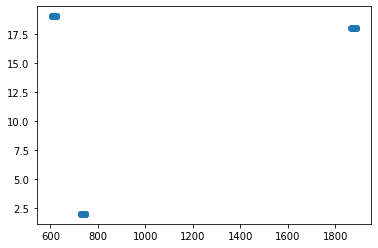

ipdb>  q


2021-11-18_18-26-40: DF Exception: Sub: R1108J, Sess: 2, BdbQuit, , file: <ipython-input-13-1b5629412fbe>, line no: 444


In [12]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload

### PARAMS ###

save_values = 0

selected_period = 'surrounding_recall' 
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on 
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0 # Hz. # 0.1 for hamming
max_ripple_rate = 1.0 # Hz. # 1.5 for hamming
max_trial_by_trial_correlation = 1.0 # if ripples correlated more than this remove them # 0.05 for hamming
max_electrode_by_electrode_correlation = 1.0 #??? # 0.2 for hamming

filter_type = 'staresina' # see local version below for details 
# butter (Vaz algorithm)
# hamming (Norman algorithm)
# hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
# hamming140250 (Same idea, but higher bands)
# staresina (Staresina et al 2015 NatNeuro)

# Additional details: 
# •Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_whole_time = 1000*np.round(12*(1.6+0.875),1) # 0.875 is average of 0.75-1.0 s so 29.7 is average encoding length
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
if remove_soz_ictal == 1:
    soz_keep = [0]
elif remove_soz_ictal == 2:
    soz_keep = [1]

### END PARAMS ###

# get region label
if selected_region == HPC_labels:
    region_name = 'HPC'
elif selected_region == ENT_labels:
    region_name = 'ENT'
elif selected_region == PHC_labels:
    region_name = 'PHC'
elif selected_region == temporal_lobe_labels:
    region_name = 'TEMPORALLOBE'
elif selected_region == MFG_labels:
    region_name = 'MFG'
elif selected_region == IFG_labels:
    region_name = 'IFG'
elif selected_region == nonHPC_MTL_labels:
    region_name = 'nonHPC_MTL'    

# analysis period
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time    
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = 2000
elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
    psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
    psth_end = 2000   

ripple_array = []; fr_array = []; 
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []; recall_index_array = []
session_events = pd.DataFrame()

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []; channel_nums = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        if exp == 'RepFR1':
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
        else:
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
        evs_free_recall = evs_free_recall[good_recalls]

        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error @@
    #         init_time = eeg_events.iloc[0].eegoffset
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
    #         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'whole_encoding':
            # grab whole encoding periods to assess lists with more ripples
            evs_enc = evs[evs.list > -1] # remove practice lists **            
            evs_enc = evs_enc[evs_enc.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 

            # beginning of encoding doesn't have a consistent code, and the last consistent one before it is COUNTDOWN_END, so search for 1st WORD after each
            
            # gotta do this for each individually since it's not a consistent offset across lists (e.g. sometimes COUNTDOWN_END shows up after ORIENT_START)
            countdown_idxs = findInd(evs_enc.type=='COUNTDOWN_END')
            first_word_idxs = []
            for countdown_idx in countdown_idxs:
                got_words = 0
                next_type = 1
                while got_words == 0:
                    if (countdown_idx+next_type)<len(evs_enc):
                        # if you find a WORD, align all the events to this index to get the encoding_starts
                        if evs_enc.iloc[countdown_idx+next_type].type == 'WORD':
                            first_word_idxs.append(countdown_idx+next_type)
                            # reset values
                            got_words = 1
                            next_type = 1                    
                        else:
                            next_type+=1
                    else: # sometimes patients stop working after countdown, so if that happens just get out of while loop and you're done!
                        got_words = 1
                        next_type = 1
            
            eeg_events = evs_enc.iloc[first_word_idxs]           
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
            
            evs_math = reader.load('all_events')
            evs_math = evs_math[(evs_math.type=='PROB')]

            # select which recalls??         
            [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_math,IRI,recall_minimum)

            # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
            good_recalls = selected_recalls_idxs & np.array(evs_math.eegoffset>-1) & np.array(evs_math.list > -1) & np.array(evs_math.iscorrect==1)
            evs_math = evs_math[good_recalls]
            eeg_events = copy(evs_math) #$$
            
            if selected_period == 'math_retrieval': #$$
                temp_eeg = reader.load_eeg(events=eeg_events, rel_start=0, rel_stop=100) # just to get sampling rate
                sr = temp_eeg.samplerate
                sr_factor = 1000/sr
                eeg_events.mstime = eeg_events.mstime+eeg_events.rectime # align to retrieval key-in times...although I don't think this is actually used again?
                eeg_events.eegoffset = eeg_events.eegoffset+[int(v) for v in np.round(eeg_events.rectime/sr_factor).values] # this is only one that matters for aligning to EEG 
                # positive means looking at EEG into the future (when rectime happens)

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                eeg_events = [] #$$

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #**
        # event X channel X time
#         import ipdb; ipdb.set_trace()

        sr = eeg.samplerate
        
        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr<990) and filter_type=='butter': #^^^
            print('Cannot use '+sub+' since using Vaz algo and sr ≤ 500!')
            continue        

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #**
                    continue
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
#         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # if we're doing big period like encoding, split in half by electrodes
        # so don't run out of memory
        if (selected_period == 'whole_encoding') | (selected_period == 'whole_retrieval'):
            half_elec = int(np.shape(eeg_ptsa)[1]/2)
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa[:,:half_elec,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa1, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa[:,half_elec:,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa = eeg_ptsa1.append(eeg_ptsa2,'channel')
        else:
            # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
                
        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        # formula from Belanger's Digital Processing of Signals
        # see https://dsp.stackexchange.com/questions/31066/how-many-taps-does-an-fir-filter-need for how to use
        
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
            ntaps = np.ceil(ntaps)
        nyquist = sr/2        
    
        
        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA  
            FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')               
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg minus bandstopped signal            
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED            
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
            ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
            kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')            
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
#             if sr == 500: # dropped below 250 Hz because too close Nyquist
#                 eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=250., filt_type='highpass',order=2).filter() 
#             elif sr >= 1000:    
#                 #this seems okay since large range far from Nyquist...problem is it likely misses key events
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster
        elif filter_type == 'staresina':
            FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)
        
        if filter_type is not 'staresina':
            eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_rip_band.apply_hilbert(envelope=True)
            eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_ied_band.apply_hilbert(envelope=True)
            
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == 1: # if no electrode_categories file then don't consisder this patient
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []
            
        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)
        
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        session_ripple_rate_by_elec = []

        for channel in electrode_search_range:

            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] in soz_keep): # selecting for SOZ or not ###
                
                total_channel_ct+=1 # total channels before artifact removal
                
                if filter_type != 'staresina':
                    # get data from MNE container 
                    eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                    eeg_ied = eeg_ied_band.get_data()[:,channel,:]
                else:
                    eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format
                    

                # select detection algorithm (note that iedlogic is same for both so always run that)
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018            
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)    
                elif filter_type == 'staresina':
                    ripplelogic = detectRipplesStaresina(eeg_rip,sr)

                if filter_type == 'butter': # ^^^
                    desired_sample_rate = 1000 # for Vaz algo

                if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
            
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]

                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # get other info specific to task periods
                
                if selected_period == 'encoding':
                    encoded_word_key_array.extend(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.extend(eeg_events.serialpos.values)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                    session_events = session_events.append(eeg_events)
                    
                    # for every word place the recall output positions
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]
                    for ln in list_nums:
                        num_words = sum(eeg_events.list==ln)
                        recall_position_array += num_words * [getSerialposOfRecalls(temp_evs_free_recall,eeg_events,ln)] # To add v, n times, to l:
                        
                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial           
                    fr_array = superVstack(fr_array,temp_fr_array)
                    
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))
                    
                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls)
                    
                    # just save the whole dataframe too so I have name and list_num (so I can align to Jim/David's analysis 2021-10-05)
                    session_events = session_events.append(eeg_events)                    
                                
                elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                    
                    list_nums = eeg_events.list.unique()  
                    for ln in list_nums:
                        num_corr_math = sum(eeg_events.list==ln)
                        list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                        recall_position_array.extend(np.arange(num_corr_math+1)) # correct math position
                    
                    # either way save the rectime array
                    rectime_array.extend(np.array(eeg_events.rectime)) 
                    encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem  
                
                elif selected_period == 'whole_encoding':
                    
                    list_nums = eeg_events.list.unique() # only lists with EEG
                    # get recalls again since evs_free_recall is designed for surrounding_recall analysis so some recalls are thrown away
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]

                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(temp_evs_free_recall,word_evs,ln)
                        # encoding serialpos
                        serialpos_array.append(temp_sp)
                        # recall position per list
                        recall_position_array.append(np.arange(len(temp_sp))+1) # 1-indexed  
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there         
                        
                        # To analyze the word and ISI periods during encoding, going to record times of each word
                        # this gets each word start time relative to encoding_start (note there is no final ISI it goes straight into distractor)
                        encoded_word_key_array.append(word_evs[word_evs.list==ln].mstime.values-eeg_events[eeg_events.list==ln].mstime.values)
                        
                        
             
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size after channel: '+str(channel))
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(eeg_events.list)
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
                             
#         # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
#         # this really only makes sense for the cluster version, since I only do a session at a time here
#         if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
#             session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
#             num_cols = len(list(session_ripple_df))
#             session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
# #             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
#             elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
#             if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
#             else:
#                 print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
    if session_ct == 1:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/john/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_channel_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, #'ripple_array2':ripple_array2, 'ripple_array_enc':ripple_array_enc,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'session_events':session_events,
                    'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)


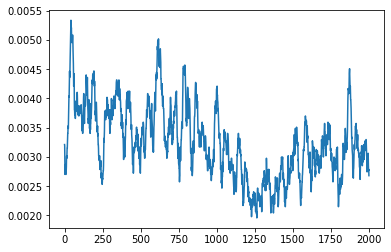

In [77]:
plot(np.mean(ripple_array,0))

## Get start_array and select subfield if HPC for free recalls

In [78]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
# if filter_type.find('hamming') != -1:
desired_sample_rate = 500.
# else:
#     desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval']:
    list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
    rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
#     session_events = session_events[updated_recalls]
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 1628
from 317 sessions from 161 subjects with trial nums:
[78. 78. 78. 78. 78. 51. 51. 51. 51. 51. 47. 47. 47. 42. 42. 42. 61. 61.
 61. 61.]
Trial sum = 71993.0
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'right sub', 'right dg', 'right dg', 'right ca1']
Number of sub_sess names: 1628
Got start_array with 12473 trials!


In [111]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

min_trials = 20 # define up here since use for ME model arrays being appended too

import warnings
%autoreload

sub_Ts1 = []; sub_Ts2 = []; 
sub_Bs1 = []; sub_Bs2 = []; 
test1 = []; test2 = []
trial_accum = []; sub_z_score = []
rate_accum = []; rate_accum2 = []; rate_accum_half = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

ME_bin2 = []; ME_bin0 = []; ME_first_half = []
ME_sessions = []; ME_subjects = []
ME_recall_num = []; ME_recall_time = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = np.array(subject_name_array)[sub_idxs]
        sub_session_name_array = np.array(session_name_array)[sub_idxs]        
       
        # now get z-score separately for each sub with ME model

        # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
        stats_bin = 500 # time bin width in ms to test stats on
        psth_start = -2000

        first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
        first_end = -100
        second_start = 200 # same idea
        second_end = 1700

        start_array.shape
        binned_first_stats_array = sub_start_array[:,int((first_start-psth_start)/sr_factor):
                                                   int((first_end-psth_start)/sr_factor)]
        binned_second_stats_array = sub_start_array[:,int((second_start-psth_start)/sr_factor):
                                                    int((second_end-psth_start)/sr_factor)]
        binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
        binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
        
        if len(binned_first_stats_array[:,2]) >= min_trials:
            
            # how many recalls/list for each recall?
            sub_avg_recall_num.append(np.mean(list_recall_num_array[sub_idxs]))        
            temp_sub_names.append(sub)

            # test first half of recall plots for first recalls only
            if recall_type_switch == 4:
                # first get the average recall times for each trial
                sub_avg_recall_time.append(np.mean(rectime_array[sub_idxs]))

                binned_half_array = sub_start_array[:,int((-2000-psth_start)/sr_factor):
                                                    int((0-psth_start)/sr_factor)]
                binned_half_array = binBinaryArray(binned_half_array,stats_bin,sr_factor)
                rate_accum_half.append(np.mean(binned_half_array))

            rate_accum.append(np.mean(binned_first_stats_array[:,2]))
            # grab the ripple rate for bin 1 second before too
            rate_accum2.append(np.mean(binned_first_stats_array[:,0])) 
            trial_accum.append(len(binned_first_stats_array[:,2]))
            trial_ct+=len(binned_first_stats_array[:,2])

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_first_stats_array)
                print(str(np.mean(binned_first_stats_array[:,2]))+' for '+str(len(binned_first_stats_array[:,2]))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model of bump v. memory after plots in next cell
            ME_bin2.extend(binned_first_stats_array[:,2])
            ME_bin0.extend(binned_first_stats_array[:,0])
            ME_recall_num.extend(list_recall_num_array[sub_idxs])
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)
            if recall_type_switch == 4:
                ME_first_half.extend(np.mean(binned_half_array,1))
                ME_recall_time.extend(rectime_array[sub_idxs])

            # get z-score of key bin v. all 8 bins
            full_sub_bin = binBinaryArray(sub_start_array,500,sr_factor)
            sub_binned_mean = np.mean(full_sub_bin,0)
            sub_z_score.append( (rate_accum[-1]-(np.mean(sub_binned_mean)))/np.std(sub_binned_mean) )

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)
                sub_Ts1.append(bin_model1.tvalues[1])
                sub_Bs1.append(bin_model1.params[1])
                test1.append(np.mean(binned_first_stats_array[:,0]))

#                 bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)                
#                 sub_Ts2.append(bin_model2.tvalues[1])                
#                 sub_Bs2.append(bin_model2.params[1])                
#                 test2.append(np.mean(binned_first_stats_array[:,2]))
        
corrected_for_nans = 0 # for below
a=1;

done binning start_arrays (printing every 10th)
0.9 for 20 trials
915
done binning start_arrays (printing every 10th)
0.5491803278688525 for 244 trials
5435
done binning start_arrays (printing every 10th)
0.19642857142857142 for 112 trials
6879
done binning start_arrays (printing every 10th)
0.8421052631578947 for 114 trials
7630
done binning start_arrays (printing every 10th)
0.2916666666666667 for 96 trials
8449
done binning start_arrays (printing every 10th)
0.3 for 20 trials
8999
done binning start_arrays (printing every 10th)
0.6213592233009708 for 103 trials
10885
done binning start_arrays (printing every 10th)
0.375 for 32 trials
13083
done binning start_arrays (printing every 10th)
0.56 for 50 trials
15874
done binning start_arrays (printing every 10th)
0.8571428571428571 for 42 trials
16506


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


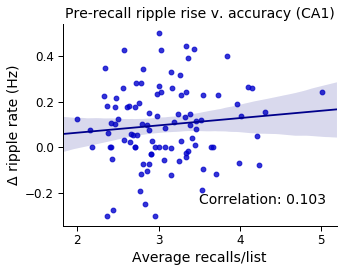

Number of low recall patients: 50
Number of high recall patients: 50
T-test between these: p = 0.0598742199568372
T-test between t-stats for each group instead: p = 0.018175219071604503
t-statistic: 2.402315400015162


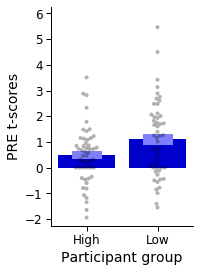

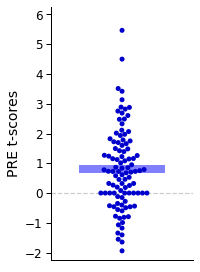

/home1/john/johnModules/general.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  second_test = num == 'nan' # some string types don't work with above line


One-sample t-test of t-scores: 5.4769581745647665e-08
t-statistic: 5.883629781132701


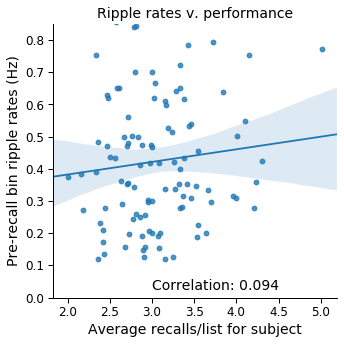

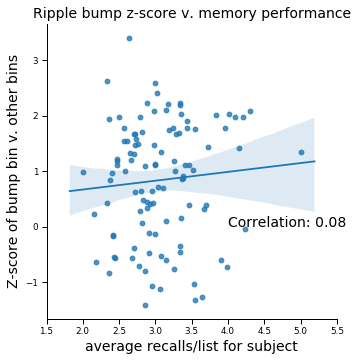

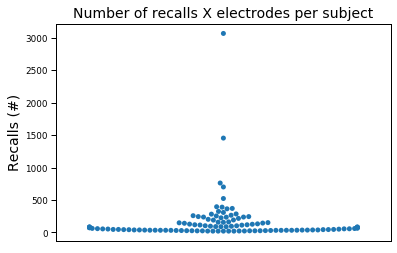

P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   ripple_rates
No. Observations:     17373     Method:               REML        
No. Groups:           108       Scale:                1.6834      
Min. group size:      20        Likelihood:           -29207.8831 
Max. group size:      3069      Converged:            Yes         
Mean group size:      160.9                                       
------------------------------------------------------------------
                          Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                 0.017    0.028 0.605 0.545 -0.038  0.072
num_recalls               0.028    0.009 3.052 0.002  0.010  0.045
subject Var               0.001                                   
subject x num_recalls Cov 0.000          

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [112]:
save_figs = 0

import seaborn as sb
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if min_trials > 0 and corrected_for_nans == 0:
    
    np.mean(sub_Ts1)
    np.std(sub_Ts1)/np.sqrt(50)
    
    good_subs = np.array(trial_accum)>=min_trials
    rate_accum = np.array(rate_accum)[good_subs]  
    rate_accum2 = np.array(rate_accum2)[good_subs] # bin 1 sec earlier
    sub_z_score = np.array(sub_z_score)[good_subs]
    sub_Ts1 = np.array(sub_Ts1)[good_subs]    
    trial_accum = np.array(trial_accum)[good_subs]    
    temp_sub_names = np.array(temp_sub_names)[good_subs]    
    
#     np.mean(sub_Ts2)
#     np.std(sub_Ts2)/np.sqrt(50)
#     sub_Ts2 = np.array(sub_Ts2)[good_subs]

    sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]
    
    corrected_for_nans = 1

# # Test 1 v. recalls/list # using t-scores here doesn't make sense since will be correlated with # recalls
# plot_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'t-scores':sub_Ts1})
# sb.lmplot(x='avg_recall_num',y='t-scores',data=plot_df)
# subs_with_no_nans = ~np.isnan(np.array(sub_Ts1))
# plot_corr = np.corrcoef(np.array(sub_avg_recall_num)[subs_with_no_nans],np.array(sub_Ts1)[subs_with_no_nans])[0][1]
# annotate('Correlation: '+str(np.round(plot_corr,3)),(4,0))
# ylabel('t-scores from mixed effects model of -600:-100 v. -1600:-1100')
# xlabel('average recalls/list')
# title('Ripple bump v. memory performance')
# show()
# scatter(x=sub_temporal_score,y=sub_Ts1)
# scatter(sub_temporal_score,sub_Ts2); show()




### $$$# subject-level figures we decided on ##$$###$

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
    
    
## Ripple rate delta between key bin and 1 sec before bin v. temporal clutsering

good_subs = (rate_accum > min_rate) & (rate_accum2 > min_rate)
temp_sub_avg_recall_num = sub_avg_recall_num[good_subs]
rate_accum_delta = rate_accum[good_subs] - rate_accum2[good_subs]
good_sub_Ts1 = sub_Ts1[good_subs]

set_pubfig()
plot_df4 = pd.DataFrame({'avg_recall_num':temp_sub_avg_recall_num,'ripple_rates':rate_accum_delta,
                        'sub_Ts1':good_sub_Ts1})
sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df4,
         scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color},
         size=4,aspect=1.25)

# gca().set(ylim=(0,0.85),xlim=(1.5,5.5))
gca().tick_params(labelsize=12)
# gca().set(xlim=(2,5))
plot_corr = np.corrcoef(temp_sub_avg_recall_num,rate_accum_delta)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3.5,-0.25))
ylabel(u'Δ ripple rate (Hz)')
xlabel('Average recalls/list')
if type(location_selected)==list:
    location_selected = location_selected[0]+location_selected[1]
title('Pre-recall ripple rise v. accuracy ('+location_selected.upper()+')')
xticks(np.arange(2,5.01,1))
gcf().tight_layout()

if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/deltaRRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


## high v. low recall patients

split_into = 2 # high v. low
delta_ripple_or_Ts = 1 # 0 for delta_ripples; 1 for sub_Ts

set_pubfig()
plot_df = copy(plot_df4) # plot_df4 is delta(rate) # plot_df5 is PRE bin
quartile_labels = range(split_into)
quartiles = pd.qcut(plot_df.avg_recall_num,split_into,labels=quartile_labels)
quartile_idxs = np.array(quartiles.values)
mean_ripples = []; ste_ripples = []
mean_mem = []; ste_mem = []
for val in np.unique(quartile_idxs):
    selected_quartile = quartile_idxs==val
    if delta_ripple_or_Ts == 0:
        mean_ripples.append(np.mean(plot_df.ripple_rates[selected_quartile]))
        ste_ripples.append(np.std(plot_df.ripple_rates[selected_quartile])/np.sqrt(len(plot_df.ripple_rates[selected_quartile])))
    else:
        mean_ripples.append(np.mean(plot_df.sub_Ts1[selected_quartile]))
        ste_ripples.append(np.std(plot_df.sub_Ts1[selected_quartile])/np.sqrt(len(plot_df.sub_Ts1[selected_quartile])))        
plot_df['idxs'] = quartile_idxs # for swarmplot

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    if delta_ripple_or_Ts == 0:
        sb.swarmplot(x='idxs',y='ripple_rates',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-0.5,0.5))
        ytick_range = np.arange(-0.5,0.501,0.25)
        ylabel(u'Δ ripple rate (Hz)')
    else:
        sb.swarmplot(x='idxs',y='sub_Ts1',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-2.25,6.25))
        ytick_range = np.arange(-2,6.01,1)        
        ylabel(u'PRE t-scores')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([1,0],{'Low','High'},fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')



print('Number of low recall patients: '+str(sum(np.array(quartiles.values))))
print('Number of high recall patients: '+str(sum(np.array(quartiles.values)==0)))
print('T-test between these: p = '+
    str(ttest_ind(plot_df.ripple_rates[np.array(quartiles.values)==1], plot_df.ripple_rates[np.array(quartiles.values)==0])[1]))
print('T-test between t-stats for each group instead: p = '+
    str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[1]))
print('t-statistic: '+str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[0]))
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==1]) # high ripple rate patients
np.mean(plot_df.ripple_rates[np.array(quartiles.values)==0])
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==1]) # high memory patients
np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==0])

tight_layout()
if save_figs == 1:
    fname = '/home1/john/SWR/figures/subject-level_plots/low_v_high_memory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+extra+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


# t-score histogram (PRE)

# (doing this at end since I ensure PRE bin and bin 1 sec earlier have > 0.1 hz RRs) 

set_pubfig()
temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts1})
if region_name == 'HPC':
    fig, ax = subplots(figsize=(3,4))
else:
    fig, ax = subplots(figsize=(3,3))

# first plot the error bars
st_err = np.std(good_sub_Ts1)/np.sqrt(len(good_sub_Ts1))
bar_bottom = np.mean(good_sub_Ts1)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# ax1 = p1.axes
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
if region_name == 'HPC':
    if selected_period == 'surrounding_recall':
        ax.set(ylim=(-2.25,6.25))
    else:
        ax.set(ylim=(-4,4))
else:
    ax.set(ylim=(-2.6,4.25))
ylabel('PRE t-scores')

tight_layout()

if save_figs == 1:
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()
# print sign test across subjects too
test_sub_Ts1 = good_sub_Ts1[~isNaN(good_sub_Ts1)]
t_stat,onesample_p = stats.ttest_1samp(test_sub_Ts1,0)
print('One-sample t-test of t-scores: '+str(onesample_p))
print('t-statistic: '+str(t_stat))


##$$$ ###



# ## For math period let's also do post-recall 
# # (doing this in post-recall bin)

# good_sub_Ts2 = sub_Ts2[good_subs] # should really use good_subs based on sub_Ts2 but just using based on pre-recall bins for now

# set_pubfig()
# temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts2})
# if region_name == 'HPC':
#     fig, ax = subplots(figsize=(3,4))
# else:
#     fig, ax = subplots(figsize=(3,3))

# # first plot the error bars
# st_err = np.std(good_sub_Ts2)/np.sqrt(len(good_sub_Ts2))
# bar_bottom = np.mean(good_sub_Ts2)-st_err
# bar_height = 2*st_err
# bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# # changes from Mike
# yticks(fontsize=12)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # now the swarm
# p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# # ax1 = p1.axes
# ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
# ax.set(xticks=[])
# ax.tick_params(labelsize=12)
# if region_name == 'HPC':
#     if selected_period == 'surrounding_recall':
#         ax.set(ylim=(-2.25,6.25))
#     else:
#         ax.set(ylim=(-4,4))
# else:
#     ax.set(ylim=(-2.6,4.25))
# ylabel('POST t-scores')

# tight_layout()

# if save_figs == 1:
#     if type(location_selected)==list:
#         location_selected = 'ca1dg'
#     fname = '/home1/john/SWR/figures/subject-level_plots/t-score_histo_POST_'+exp+'_'+region_name+'_'+\
#         location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
#     savefig(fname,format='pdf',transparent=True)
# save_fig = 0
# show()
# # print sign test across subjects too
# test_sub_Ts2 = good_sub_Ts2[~isNaN(good_sub_Ts2)]
# _,onesample_p = stats.ttest_1samp(test_sub_Ts2,0)
# print('One-sample t-test of t-scores: '+str(onesample_p))


## Pre-recall ripple rates v. temporal clutsering

set_pubfig()
plot_df5 = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum})
# take only rates > usually defined 0.1 Hz minimum
plot_df5 = plot_df5[plot_df5.ripple_rates>0.1]

fig1 = sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df5) #,
#                  line_kws = {'color': 'black'},scatter_kws = {'color': 'black'})
gca().set(ylim=(0,0.85))
gca().tick_params(labelsize=12)
# gca().set_xticks(gca().get_xticks())
# gca().set_xticklabels(gca().get_xticks(),rotation=0)
# gca().set_ylabel(size=14)
# gca().set(xticks=np.arange(2,5,0.5))

plot_corr = np.corrcoef(sub_avg_recall_num,rate_accum)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3,0.025))
ylabel('Pre-recall bin ripple rates (Hz)')
xlabel('Average recalls/list for subject')
title('Ripple rates v. performance')
gcf().tight_layout()
show()


# Z-scores v. temporal clustering
plot_df = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'sub_z_score':sub_z_score})
sb.lmplot(x='avg_recall_num',y='sub_z_score',data=plot_df)
plot_corr = np.corrcoef(sub_avg_recall_num,sub_z_score)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(4,0))
ylabel('Z-score of bump bin v. other bins')
xlabel('average recalls/list for subject')
title('Ripple bump z-score v. memory performance')
gca().set(xlim=(1.5,5.5))
show()    

# trial histogram
set_pubfig()
sb.swarmplot(y=trial_accum) 
gca().set(xticks=[])
ylabel('Recalls (#)')
title('Number of recalls X electrodes per subject')
show()


## let's do a mixed model on this data too since correlation isn't ideal due to varying sample sizes across patients ##

rr_df = pd.DataFrame(data={'session':ME_sessions,'subject':ME_subjects,
                           'ripple_rates':np.array(ME_bin2)-np.array(ME_bin0),'num_recalls':ME_recall_num
                          })
vc = {'session':'0+session'} # to nest sessions in subjects
# intercept included when using smf
rr_model = smf.mixedlm("ripple_rates ~ num_recalls", rr_df, groups="subject",
                       vc_formula=vc, re_formula="1+num_recalls") 
rr_fit = rr_model.fit(reml=True, method='nm',maxiter=2000)

print('P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)')
print(rr_fit.summary()) #pvalues)
print('Key num_recalls X bin interaction: '+str(np.round(rr_fit.pvalues[1],4)))

a=1;

## PSTH with mixed effect CIs

In [79]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(12473, 36)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_lin

SEs created!
Are these three the same length?? They should be!


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(12473, 36)

12473

12473

# Stats on key recall-aligned bins

done binning start_arrays


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
Test 1 p-value: 0.2519144202272673
Test 2 p-value: 0.11077600654530326
12473 recalls


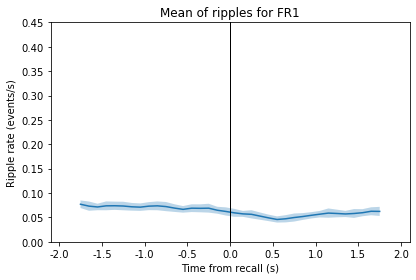

In [80]:
save_plot_data = 1

plot_sig_bars = 0

# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
title('Mean of ripples for '+exp)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-ANLIPLOT.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

# Once you've saved recall_type 4 and 6 for all 3 algorithms, plot them!

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
Number of subjects: 130
Number of sessions: 264
Number of electrodes: 331
1st recalls: 13701 recalls
Test 1 p-value: 0.24001733532927072
Test 2 p-value: 0.0038045543804711666
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole-ANLIPLOT.p
≥2nd recalls: 17567 recalls
Test 1 p-value: 3.137947906505725e-28
Test 2 p-value: 2.0847414508349986e-07
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_butter_whole-ANLIPLOT.p
Number of subjects: 112
Number of sessions: 231
Number of electrodes: 286
1st recalls: 11834 recalls
Test 1 p-value: 0.1699797910837768
Test 2 p-value: 0.02318093094003073
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_butter_whole-ANLIPLOT.p
≥2nd recalls: 15311 recalls
Test 1 p-value: 1.239203302360479e-15
Test 2 p-value: 0.0017216198839395485
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
Number

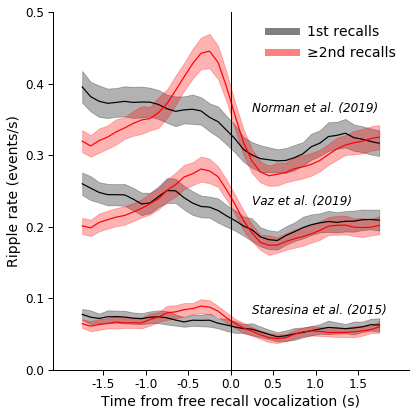

In [97]:
# load data from each

save_plot = 0

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1' # 'dg' 'ca1' ''
extra = '-ANLIPLOT' #'-GT_5000' # '-LT_5000' # '' # '-GT_5000' # LT 5000 and GT 5000 are control analyses 
# for first 5000 ms of retrieval period or not

recall_minimum = 2000
pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

set_pubfig()

for filter_type in ['hamming','butter','staresina']:
    
    for p,recall_type_switch in enumerate([4,6]):

        # get strings for path name for save and loading cluster data
        soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

        if ((p==0)&(filter_type == 'hamming')):
            subplots(1,1,figsize=(6,6)); ax = plt.gca()           
        if p == 0:
            color = (0,0,0)
            label = '1st recalls'
            line_dist = 0.175
        else:
            label = '≥2nd recalls'
            line_dist = 0.15
            if location_selected == 'ca1':
                color = (1,0,0)
#             elif location_selected == 'dg':
#                 color = (1,0,0)
#             elif ((location_selected == 'ca1dg') | (location_selected == '')):
#                 color = (0.5,0,0.5)
#             elif region_name == 'PHC':
#                 color = (0,0.5,0.5)
#             elif region_name == 'ENT':
#                 color = (0.5,0.5,0)

        path_name = '/home1/john/SWR/figures/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                          '_'+filter_type+'_'+sub_selection+extra+'.p')   
        print(fn)
        with open(fn,'rb') as f:
            dat = pickle.load(f)
            bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; SE_plot = dat['SE_plot']; num_trials = dat['num_trials'];
            bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']
            binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array'];
            subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array'];
            electrode_array = dat['electrode_array']
            
        if p == 0:
            print('Number of subjects: '+str(len(np.unique(subject_name_array))))
            print('Number of sessions: '+str(len(np.unique(session_name_array))))   
            subject_channel_array = []
            for i_session in range(len(session_name_array)):
                subject_channel_array.append(subject_name_array[i_session]+electrode_array[i_session])
            print('Number of electrodes: '+str(len(np.unique(subject_channel_array)))) 

        # make plot
        xr = bin_centers #np.arange(psth_start,psth_end,binsize)

        # plot smoothed mean +/- CI
        if pad > 0:
            SE_plot = fixSEgaps(SE_plot) # fix gaps when using 40% of data

            plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
            fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')
        else:
            plot(xr,PSTH)
            fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:],
                         color=color, alpha = 0.3, label='_nolegend_')

    #     # plot bands of significance
    #     if bin_model1.pvalues[1] < 0.05:
    #         plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
    #              color=color,label='_nolegend_')
    #     if bin_model2.pvalues[1] < 0.05:
    #         plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
    #              color=color,label='_nolegend_')
        print(label+': '+str(num_trials)+' recalls')
        print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
        print('Test 2 p-value: '+str(bin_model2.pvalues[1]))


xlabel('Time from free recall vocalization (s)')
ylabel('Ripple rate (events/s)')
# if filter_type == 'hamming':
ylim = 0.5 # keep it here since occasionally CIs get kinda high
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
# else: # for Vaz and hamming125200
#     ylim = 0.45

ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')

# recent changes suggested by Mike
label_start = -1500; label_end = 1500
xticks(np.arange(label_start,label_end+1,500),np.arange(label_start/1000,label_end/1000+1,500/1000),fontsize=12)
yticks(fontsize=12)
leg = ax.legend(['1st recalls','≥2nd recalls'],frameon=False,prop={'size': 14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
    legobj.set_alpha(0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

text(250,0.36,'Norman et al. (2019)',style='italic', fontsize=12)
text(250,0.23,'Vaz et al. (2019)',style='italic', fontsize=12)
text(250,0.0775,'Staresina et al. (2015)',style='italic', fontsize=12)

# if location_selected == '':
#     title(region_name)
# else:
#     title(location_selected)
tight_layout()

if save_plot == 1:
    plt.savefig('../figures/PSTHplots/'+exp+'_'+'PSTH_by_region-'+region_name+'_'+location_selected+'-'+str(recall_type_switch)+'_'+
                filter_type+'_'+sub_selection+extra+'.pdf',transparent=True) 

a=1;

# do interaction stats

In [92]:
# do separate test of 1st v. ≥2nd

import statsmodels.formula.api as smf

region_name = 'HPC' # 'ENT' # 'PHC' #'HPC'
location_selected = 'ca1' # 'ca1', 'dg'; '' for 'ENT' or 'PHC'
remove_soz_ictal = False
selected_period = 'surrounding_recall'

sub_selection = 'whole' # 'second_half','whole'
extra = '-ANLIPLOT'

for filter_type in ['hamming','butter','staresina']:

    for test in [1,2]: # tests 1 and 2 are pre and post recall

        session_name = []
        subject_name = []
        ripple_rates = []
        recall_indicator = []
        bin_indicator = []

        for i_rec,recall_type_switch in enumerate([4,6]):

            recall_minimum = 2000            
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

            path_name = '/home1/john/SWR/figures/'+subfolder
            fn = os.path.join(path_name,
                'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                              '_'+filter_type+'_'+sub_selection+extra+'.p')   
            print(fn)
            with open(fn,'rb') as f:
                dat = pickle.load(f)
                binned_first_stats_array = dat['binned_first_stats_array']; binned_second_stats_array = dat['binned_second_stats_array']
                subject_name_array = dat['subject_name_array']; session_name_array = dat['session_name_array']

                for i_bin,bn in enumerate([0,2]): # for test 1, 1 second before v. key bin; for test 2, key bin v. 1 second after

                    recall_indicator.extend(np.tile(i_rec,len(session_name_array)))
                    bin_indicator.extend(np.tile(i_bin,len(session_name_array)))
                    session_name.extend(session_name_array)
                    subject_name.extend(subject_name_array)
                    # remember, the binned_stats_arrays are 500 ms each from -1600:-100 or 200:1700 ms
                    if test == 1:
                        ripple_rates.extend(binned_first_stats_array[:,bn])
                    else:
                        ripple_rates.extend(binned_second_stats_array[:,2-bn])

        bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,'bin_indicator':bin_indicator,
                                    'recall_indicator':recall_indicator,'ripple_rates':ripple_rates})
        vc = {'session':'0+session'}
        model_setup = smf.mixedlm("ripple_rates ~ bin_indicator*recall_indicator",
                                    bin_df, groups="subject", vc_formula=vc, re_formula='bin_indicator*recall_indicator')

    #     bin_model = model_setup.fit(reml=True,method='powell') # shouldn't use this--it doesnt seem to converge for all the coefficients
        bin_model = model_setup.fit(reml=True,method='nm',maxiter=2000) # works for PHC, whole

        if test == 1:
            print(bin_model.summary())
            print('Test 1 interaction p-value: '+str(bin_model.pvalues[3]))
        else:
            print('Test 2 interaction p-value: '+str(bin_model.pvalues[3]))

/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_hamming_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_hamming_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               62536               Method:                         REML        
No. Groups:                     130                 Scale:                          0.8307      
Min. group size:                14                  Likelihood:                     -83156.4527 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                481.0                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.355

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 interaction p-value: 0.493791729747167
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_butter_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_butter_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               54290               Method:                         REML        
No. Groups:                     112                 Scale:                          0.4981      
Min. group size:                14                  Likelihood:                     -58223.7138 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                484.7                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.240

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 interaction p-value: 0.8069559962669485
/home1/john/SWR/figures/FIRSTRECALL/SWR_FR1_HPC_ca1_4_soz_in_staresina_whole-ANLIPLOT.p
/home1/john/SWR/figures/NOTFIRSTRECALLS/SWR_FR1_HPC_ca1_6_soz_in_staresina_whole-ANLIPLOT.p


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             ripple_rates
No. Observations:               58276               Method:                         REML        
No. Groups:                     109                 Scale:                          0.1527      
Min. group size:                18                  Likelihood:                     -28005.3583 
Max. group size:                8802                Converged:                      Yes         
Mean group size:                534.6                                                           
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              0.072

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Test 2 interaction p-value: 0.9599138384092337


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
